In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


In [2]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

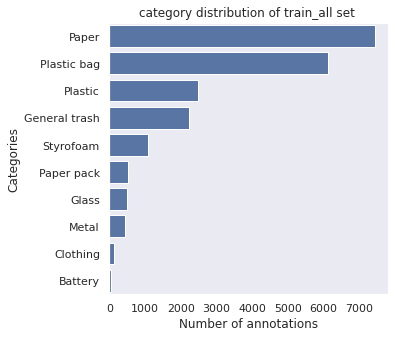

In [3]:
dataset_path  = '../../input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories

cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [4]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [5]:
# class (Categories) 에 따른 index 확인 (0~10 : 총 11개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,General trash,2225.0
2,Paper,7448.0
3,Paper pack,527.0
4,Metal,449.0
5,Glass,488.0
6,Plastic,2472.0
7,Styrofoam,1074.0
8,Plastic bag,6114.0
9,Battery,50.0


In [6]:
class_colormap = pd.DataFrame(np.array([['Background','0', '0', '0' ],['General trash','128', '0', '0'], ['Paper','0', '128', '0'], 
['Paper pack','128', '128', '0'], ['Metal','0', '0', '128',], ['Glass','128', '0', '128'], ['Plastic','0', '128', '128'], ['Styrofoam', '128', '128', '128'],
['Plastic bag','64', '0', '0'], ['Battery','192', '0', '0'],['Clothing',64, 128, 0]]), columns=['name','r', 'g', 'b'])


class_colormap['r'] = class_colormap['r'].apply(lambda x :int(x))
class_colormap['g'] = class_colormap['g'].apply(lambda x :int(x))
class_colormap['b'] = class_colormap['b'].apply(lambda x :int(x))
print(type(class_colormap['r'][0]))

<class 'numpy.int64'>


In [7]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [8]:

category = {
    "Background": 0,
    "General trash":1,
    "Paper":2,
    "Paper pack":3,
    "Metal":4,
    "Glass":5,
    "Plastic":6,
    "Styrofoam":7,
    "Plastic bag":8,
    "Battery":9,
    "Clothing":10,
}

def get_image_ann_id(coco:COCO, image:dict):
    ann_ids = coco.getAnnIds(imgIds=image['id'])
    return ann_ids, len(ann_ids)


def get_single_ann_image(target_categories:list, path:str, coco_from:COCO):
    """
        1. json file load
        2. json file load using coco library
        3. finding an image that has a single object that you're aiming for
    """
    target = []
    for t_cat in target_categories:
        target.append(category[t_cat])
    print("target class:", target)

    json_file = None
    with open(path, 'r') as f:
        json_file = json.load(f)

    images = json_file["images"]

    single_obj_images = []
    for image in images:
        ids, length = get_image_ann_id(coco_from, image)
        if True : # length == 1:
            anns_info = coco_from.loadAnns(ids)
            for ann in anns_info: # 한개라도 target annotation이 있으면 이미지 추가
                if ann["category_id"] in target:
                    single_obj_images.append(image['file_name'])
                    break

    return single_obj_images

In [9]:
def target_show(target_categories, data_path, num_examples=None):
    '''
    특정 카테고리의 이미지만 출력합니다. 
    '''
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                            edgecolor=webcolors.rgb_to_hex(rgb), 
                            label=category) for category, rgb in category_and_rgb]

    json_path = os.path.join(data_path, 'train.json')
    coco = COCO(json_path)

    single_obj_images = get_single_ann_image(target_categories, json_path, coco)
    if num_examples == None:
        num_examples = len(single_obj_images)

    fig, axes = plt.subplots(ncols=2, nrows=len(single_obj_images), sharex=True, sharey=True,  figsize=(10, 4*num_examples))

    for i, ax in enumerate(axes.flat):

        if i % 2 == 0:
            images = cv2.imread(os.path.join(data_path, single_obj_images[i//2]))
            images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
            images /= 255.0
            ax.imshow(images)
            ax.grid(False)
            ax.set_title("input image : {}".format(single_obj_images[i//2]), fontsize = 15)
            
        elif i % 2 == 1:
            mask = cv2.imread(os.path.join(data_path, 'SegmentationClass', single_obj_images[i//2]).replace('jpg','png'))
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB).astype(np.float32)
            # mask /= 255.0
            ax.imshow(mask)
            ax.grid(False)
            ax.set_title("masks : {}".format(single_obj_images[i//2].replace('jpg','png')), fontsize = 15)
            ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            

    plt.show()

loading annotations into memory...
Done (t=3.77s)
creating index...
index created!
target class: [9]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

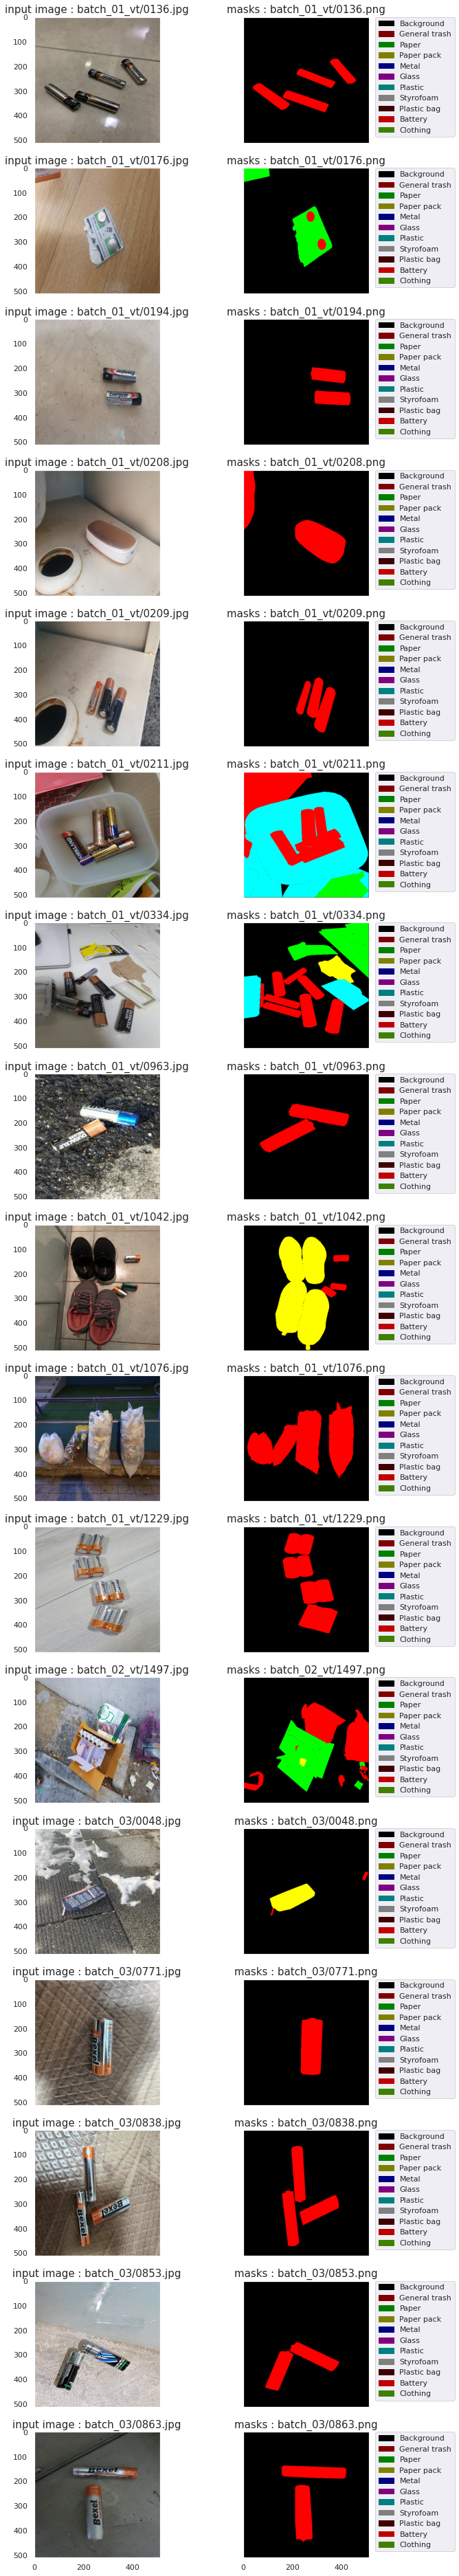

In [10]:
target_show(['Battery'], '/opt/ml/segmentation/input/data')